# DDPM Explore the latents

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from main import FLAGS, UNet, GaussianDiffusionSampler, evaluate
import torch
import os
from tqdm.autonotebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# configs used for the checkpoint
T = 1000
ch = 128
ch_mult = [1, 2, 2, 2]
attn = [1]
num_res_blocks = 2
dropout = 0.1
beta_1=0.0001
beta_T=0.02
img_size= 32
mean_type = 'epsilon'
var_type = 'fixedlarge'
logdir = 'logs/DDPM_CIFAR10_EPS'
device = 'cuda'

num_images = 1
batch_size = 64
fid_cache= './stats/cifar10_train_tmp.npz'
fid_use_torch=False

In [5]:
def evaluate(sampler, model):
    model.eval()
    with torch.no_grad():
        images = []
        desc = "generating images"
        for i in trange(0, num_images, batch_size, desc=desc):
            bs = min(batch_size, num_images - i)
            x_T = torch.randn((bs, 3, img_size, img_size))
            batch_images = sampler(x_T.to(device)).cpu()
            images.append((batch_images + 1) / 2)
        images = torch.cat(images, dim=0).numpy()
    model.train()
    return images

In [6]:
model = UNet(
    T=T, ch=ch, ch_mult=ch_mult, attn=attn,
    num_res_blocks=num_res_blocks, dropout=dropout)
sampler = GaussianDiffusionSampler(
    model, beta_1, beta_T, T, img_size=img_size,
    mean_type=mean_type, var_type=var_type).to(device)
# if FLAGS.parallel:
#     sampler = torch.nn.DataParallel(sampler)

# load model and evaluate
ckpt = torch.load(os.path.join(logdir, 'ckpt.pt'))
model.load_state_dict(ckpt['net_model'])
# samples = evaluate(sampler, model)
# print("Model     : IS:%6.3f(%.3f), FID:%7.3f" % (IS, IS_std, FID))
# save_image(
#     torch.tensor(samples[:256]),
#     os.path.join(FLAGS.logdir, 'samples.png'),
#     nrow=16)

<All keys matched successfully>

In [7]:
# plt.imshow(samples[0].transpose([1, 2, 0]))

In [117]:
latent_at = [200, 400, 600, 800, 1000]
latents = []
preds = []

with torch.no_grad():
    model.eval()
    x_T = x_t = torch.randn((1, 3, img_size, img_size)).to(device)
    for time_step in tqdm(reversed(range(T))):
        
        t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
#         print(t)
        mean, log_var, interm = sampler.p_mean_variance(x_t=x_t, t=t)
    
        # no noise when t == 0
        if time_step > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = 0
        x_t = mean + torch.exp(0.5 * log_var) * noise
        
        
        if T - time_step in latent_at:
            latents.append([each.cpu() for each in interm])
            x_0 = x_t
            x_0 = torch.clip(x_0, -1, 1)
            preds.append(x_0.cpu())

#         if time_step <= T - 1:
#             break
    x_0 = x_t
    x_0 = torch.clip(x_0, -1, 1)
    model.train()

0it [00:00, ?it/s]

In [118]:
def prepare_img(x):
    return (x.permute([0, 2, 3, 1]).cpu() + 1) / 2

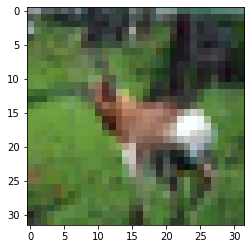

In [119]:
samples = prepare_img(x_0)
plt.imshow(samples[0])

In [120]:
print('n_latent:', len(latents))
print('n_layer:', len(latents[0]))

n_latent: 5
n_layer: 6


latent: 1 256 4 4
latent: 1 256 4 4
latent: 1 256 8 8
latent: 1 256 16 16
latent: 1 128 32 32
latent: 1 3 32 32


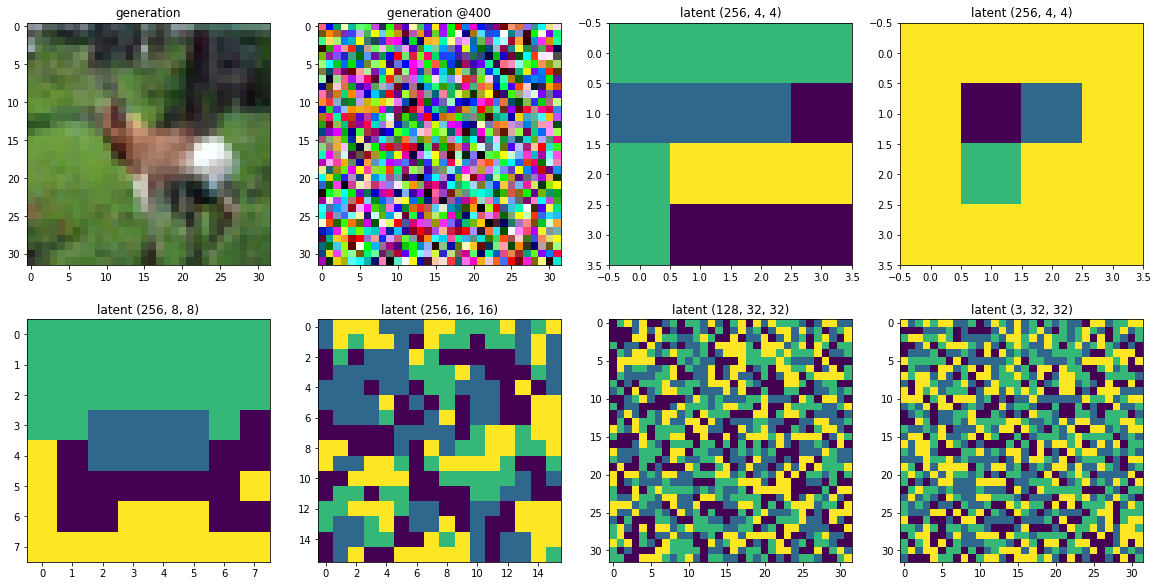

In [140]:
from kmeans_pytorch import kmeans

K = 4
i_latent = 1

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ax = ax.flatten()
ax[0].imshow(samples[0])
ax[0].set_title('generation')
x0 = prepare_img(preds[i_latent])
ax[1].imshow(x0[0])
ax[1].set_title(f'generation @{latent_at[i_latent]}')

for i_layer in range(6):
    # (n, c, h, w)
    x = latents[i_latent][i_layer].cuda()
    n, c, h, w = x.shape
    print('latent:', n, c, h, w)
    # (n, h, w, c)
    x = x.permute([0, 2, 3, 1])
    # (n*h*w, c)
    x = x.reshape([n*h*w, c])
    ids, clusters = kmeans(X=x, num_clusters=K, device=device, tqdm_flag=False)

    ax[2 + i_layer].imshow(ids.reshape([h, w]))
    ax[2 + i_layer].set_title(f'latent {(c, h, w)}')

In [30]:
import torch.nn.functional as F
from torch import nn

latent: 1 256 4 4
latent: 1 512 4 4
latent: 1 1024 8 8
latent: 1 2048 16 16
latent: 1 4096 32 32
latent: 1 8192 32 32


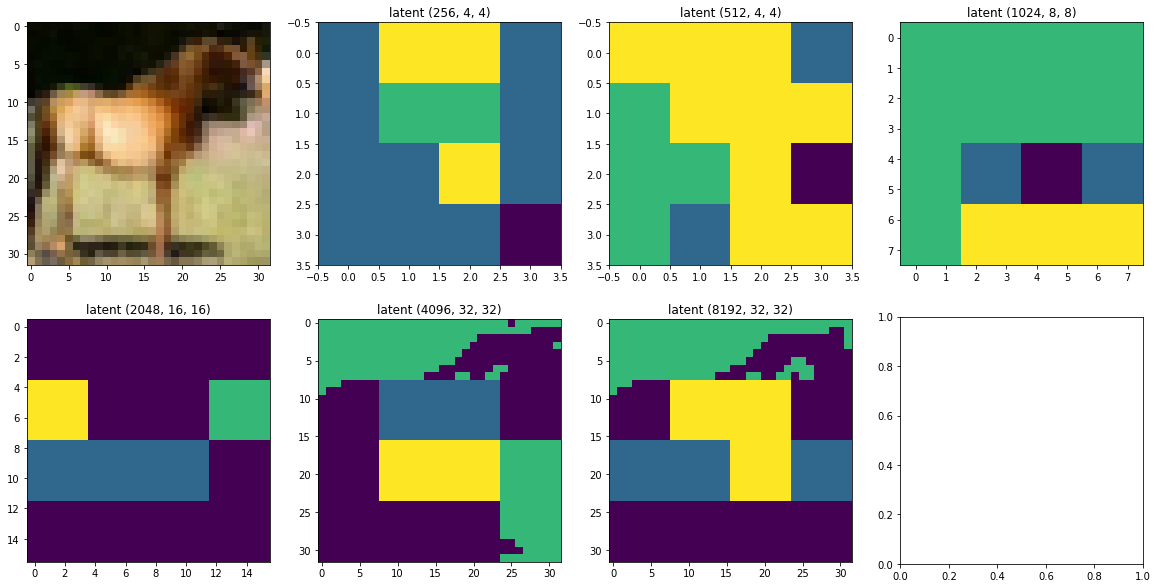

In [33]:
from kmeans_pytorch import kmeans

K = 4
i_latent = 4

x = None

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ax = ax.flatten()
ax[0].imshow(samples[0])

for i_layer in range(6):
    # (n, c, h, w)
    new = latents[i_latent][i_layer].cuda()
    if x is None:
        x = new
    else:
        _, _, h, w = x.shape
        _, _, hh, ww = new.shape
        if (hh, ww) != (h, w):
            x = F.interpolate(x, (hh, ww))
            
        _, cc, _, _ = new.shape
        proj = nn.Conv2d(cc, x.shape[1], kernel_size=1).cuda()
        new = proj(new)
        x = torch.cat([x, new], dim=1)
        
    n, c, h, w = x.shape
    print('latent:', n, c, h, w)
    # (n, h, w, c)
    tmp = x.permute([0, 2, 3, 1])
    # (n*h*w, c)
    tmp = tmp.reshape([n*h*w, c])
    ids, clusters = kmeans(X=tmp, num_clusters=K, device=device, tqdm_flag=False)

    ax[1 + i_layer].imshow(ids.reshape([h, w]))
    ax[1 + i_layer].set_title(f'latent {(c, h, w)}')